Image Processing
    Taylor Rubalcava

In [24]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from imageio.v3 import imread

# Load Images

In [25]:
# Load in the image.
image = imread('./Data/balloons_color.jpg', mode='F') * 1./255

# Create the noisy image by altering pixels from the original image.
noisy_image = image.copy()
x, y = image.shape
for i in range(x*y//50):
	noisy_image[randint(x), randint(y)] = (127 + randint(127)) * 1./255

Display the original image, the noisy image, and the cleaned image.
Using anisotropic diffusion.

In [26]:
def anis_diff(U, N, g, lambda_=0.25):
    """
    Run the Anisotropic Diffusion differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        g (callable): diffusion function.
        lambda_ (float): scaling coefficient.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    m,n = U.shape # m is the number of rows and n is the number of columns
    U = np.pad(U, mode = 'edge',pad_width = 1)
    row_start, row_end = 1, m + 1
    col_start, col_end = 1, n + 1
    
    for _ in range(N):
        current_row_col = U[row_start:row_end, col_start:col_end]
        prior_row = U[row_start - 1 : row_end - 1, col_start:col_end]
        next_row = U[row_start + 1:row_end + 1, col_start:col_end]
        prior_column = U[row_start:row_end, col_start - 1:col_end - 1]
        next_column = U[row_start:row_end, col_start + 1:col_end + 1]

        U[row_start:row_end, col_start:col_end] = current_row_col + lambda_ * (
            g(np.abs(prior_column - current_row_col)) * (prior_column - current_row_col) +
            g(np.abs(next_column - current_row_col)) * (next_column - current_row_col) +
            g(np.abs(prior_row - current_row_col)) * (prior_row - current_row_col) +
            g(np.abs(next_row - current_row_col)) * (next_row - current_row_col)
        )

    return U[row_start:row_end, col_start:col_end]


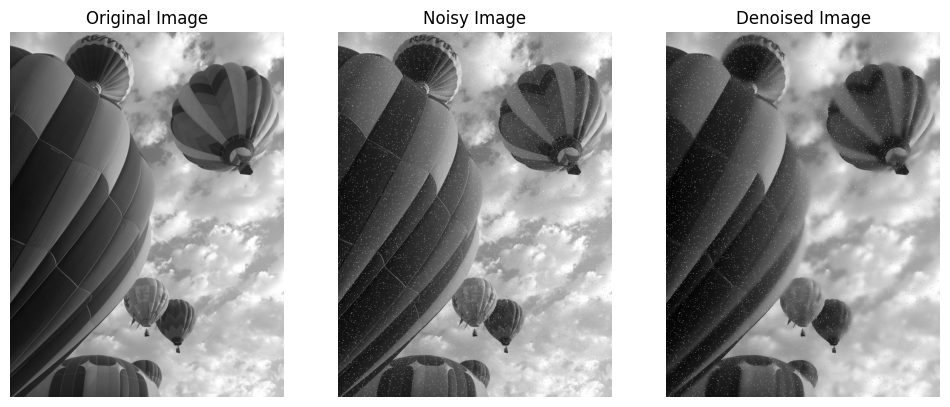

In [27]:
# Testing problem 1
sigma = 0.1
lambda_ = 0.25
N = 20
def g(x):
    return np.exp(-(x / sigma) ** 2)

# Run the Anisotropic Diffusion differencing scheme on the noisy image.
denoised_image = anis_diff(noisy_image, N, g, lambda_)

# Plot the original, noisy, and denoised images.
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(noisy_image, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')
ax[2].imshow(denoised_image, cmap='gray')
ax[2].set_title('Denoised Image')
ax[2].axis('off')
plt.show()

Running the function on the noisy image with $\lambda=0.25$.
Experimenting with the number of iterations until the resulting image looks close to the original image.
Displaying the original image, the noisy image, and the cleaned image.

In [28]:
def min_bias(U, N, lambda_=0.25):
    """
    Run the Minimum Bias differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    m,n = U.shape # m is the number of rows and n is the number of columns
    U = np.pad(U, mode = 'edge',pad_width = 1)
    row_start, row_end = 1, m + 1
    col_start, col_end = 1, n + 1
    
    for _ in range(N):
        current_row_col = U[row_start:row_end, col_start:col_end]
        prior_row = U[row_start - 1 : row_end - 1, col_start:col_end]
        next_row = U[row_start + 1:row_end + 1, col_start:col_end]
        prior_column = U[row_start:row_end, col_start - 1:col_end - 1]
        next_column = U[row_start:row_end, col_start + 1:col_end + 1]

        # Creating G
        G = np.stack([np.abs(prior_column - current_row_col), np.abs(next_column - current_row_col), 
                     np.abs(prior_row - current_row_col), np.abs(next_row - current_row_col)])
        
        G = np.partition(G, 2, axis = 0)[2, : , :]


        U[row_start:row_end, col_start:col_end] = current_row_col + lambda_ * (
            G * (prior_column - current_row_col) +
            G * (next_column - current_row_col) +
            G * (prior_row - current_row_col) +
            G * (next_row - current_row_col)
        )

    return U[row_start:row_end, col_start:col_end]

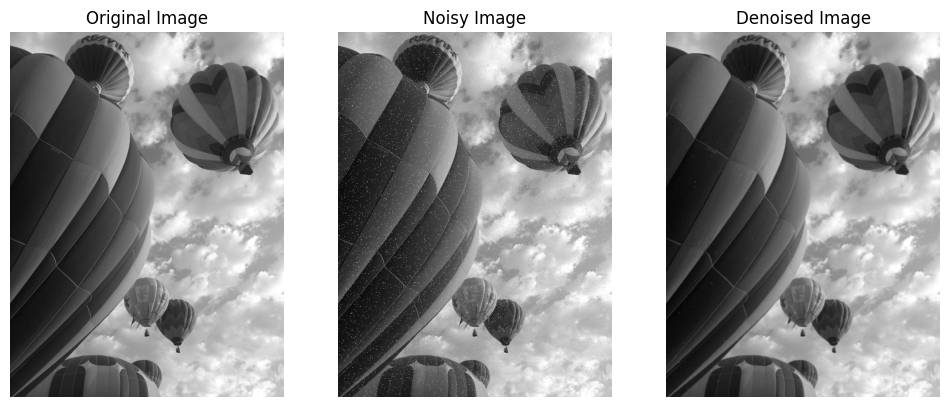

In [29]:
# Testing problem 2
lambda_ = 0.25
N = 20

# Run the Anisotropic Diffusion differencing scheme on the noisy image.
denoised_image = min_bias(noisy_image, N, lambda_)

# Plotting the original, noisy, and denoised images.
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(noisy_image, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')
ax[2].imshow(denoised_image, cmap='gray')
ax[2].set_title('Denoised Image')
ax[2].axis('off')
plt.show()

Running the function on the noisy image with $\Delta t =$ 1e-3, $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$.
Experimenting with the number of iterations until the noise is hard to see.
Displaying the original image, the noisy image, and the cleaned image.

In [30]:
def grad_desc(U, N, lambda_, delta_t, delta_x=1, delta_y=1):
    """
    Run the Gradient Descent differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        delta_t (float): change in time.
        delta_x (float): change in x.
        delta_y (float): change in y.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    m,n = U.shape # m is the number of rows and n is the number of columns
    f = U.copy() # The original noisy image
    U = np.pad(U, mode = 'edge',pad_width = 1)
    row_start, row_end = 1, m + 1
    col_start, col_end = 1, n + 1
    
    for _ in range(N):
        current_row_col = U[row_start:row_end, col_start:col_end]
        prior_row = U[row_start - 1 : row_end - 1, col_start:col_end]
        next_row = U[row_start + 1:row_end + 1, col_start:col_end]
        prior_column = U[row_start:row_end, col_start - 1:col_end - 1]
        next_column = U[row_start:row_end, col_start + 1:col_end + 1]

        U[row_start:row_end, col_start:col_end] = current_row_col + -delta_t * (
            current_row_col - f - lambda_ * (
                ((prior_column - 2 * current_row_col + next_column) / (delta_x ** 2)) +
                ((prior_column - 2 * current_row_col + next_column) / (delta_y ** 2))
            )
        )

    return U[row_start:row_end, col_start:col_end]


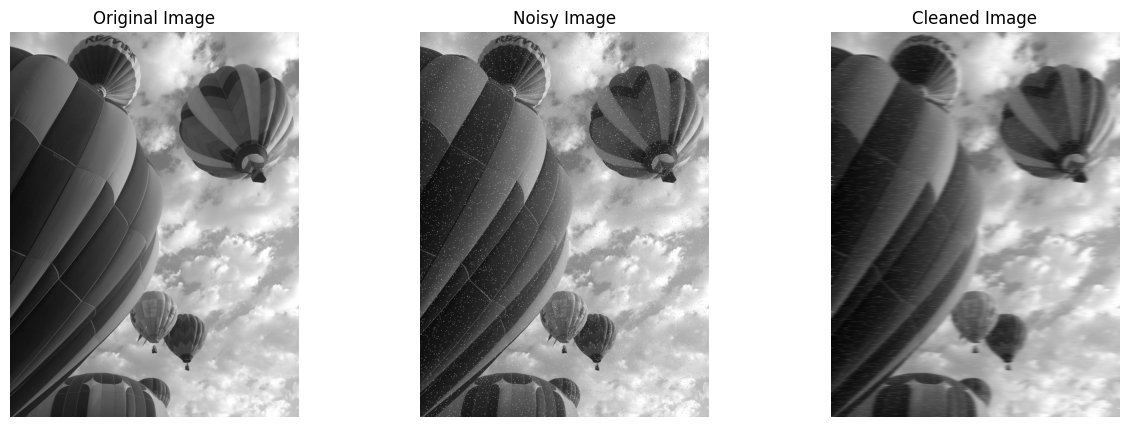

In [31]:
# Testing problem 3
lambda_ = 40
N = 100
delta_t = 1e-3
delta_x = 1
delta_y = 1

# Run the gradient descent differencing scheme on the noisy image.
denoised_image = grad_desc(noisy_image, N, lambda_, delta_t, delta_x, delta_y)

# Plotting the original, the noisy image, and the cleaned image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')
axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title('Cleaned Image')
axes[2].axis('off')
plt.show()

Deriving the update scheme for the total variations method.
Finishing the following function that implements this method.
Use a centered difference to approximate the values for $u_{x}$ and $u_{y}$.
Running the function on the noisy image using $\Delta t =$ 1e-3, $\lambda = 1, \epsilon =$ 1e-6, $\Delta x = 1,$ and $ \Delta y = 1$.
Experimenting with the number of iterations until the resulting image looks close to the original image.
Displaying the original image, the noisy image, and the cleaned image.

In [32]:
def total_var(U, N, lambda_, epsilon, delta_t, delta_x=1, delta_y=1):
    """
    Run the Total Variations differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        epsilon (float): adjustment for denominator.
        delta_t (float): change in time.
        delta_x (float): change in x.
        delta_y (float): change in y.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    m,n = U.shape # m is the number of rows and n is the number of columns
    f = U.copy() # The original noisy image
    U = np.pad(U, mode = 'edge',pad_width = 1)
    row_start, row_end = 1, m + 1
    col_start, col_end = 1, n + 1

    for _ in range(N):

        current_row_col = U[row_start:row_end, col_start:col_end]
        prior_row = U[row_start - 1 : row_end - 1, col_start:col_end]
        next_row = U[row_start + 1:row_end + 1, col_start:col_end]
        prior_column = U[row_start:row_end, col_start - 1:col_end - 1]
        next_column = U[row_start:row_end, col_start + 1:col_end + 1]

        U_x = (U[:-2, 1:-1] - U[2:, 1:-1])/(2*delta_x)
        U_xx = (U[:-2, 1:-1] - 2*U[1:-1, 1:-1] + U[2:, 1:-1])/(delta_x**2)
        U_y = (U[1:-1, :-2] - U[1:-1, 2:])/(2*delta_y)
        U_yy = (U[1:-1, :-2] - 2*U[1:-1, 1:-1] + U[1:-1, 2:])/(delta_y**2)
        pad_U_x = np.pad(U_x, mode="edge", pad_width=1)
        pad_U_y = np.pad(U_y, mode="edge", pad_width=1)
        U_xy = (pad_U_x[1:-1, :-2] - pad_U_x[1:-1, 2:])/(2*delta_y)

        U[row_start:row_end, col_start:col_end] = current_row_col + delta_t * (
            - lambda_ * (current_row_col - f) + (U_xx * U_y**2 + U_yy * U_x**2 - 2 * U_x * U_y * U_xy) / ((epsilon + U_x ** 2 + U_y ** 2) ** (3/2))
        )

    return U[row_start:row_end, col_start:col_end]

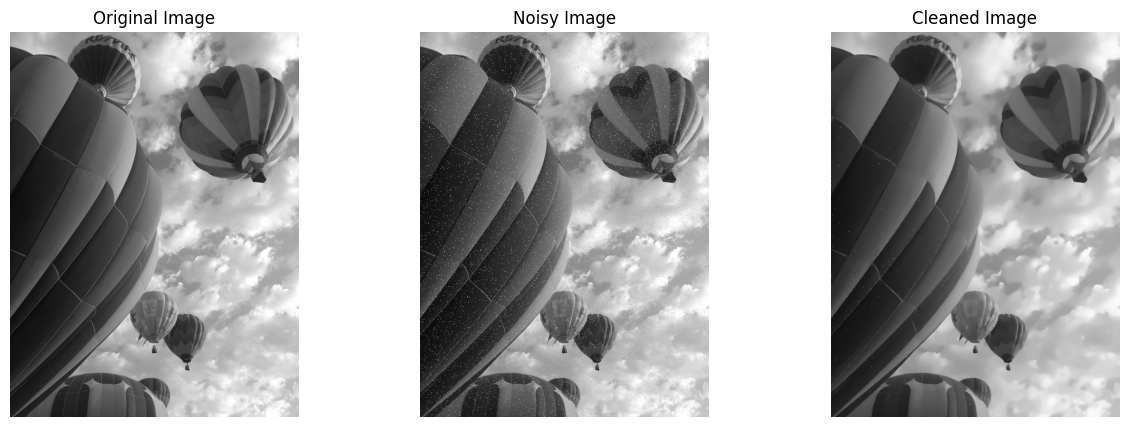

In [33]:
# Testing problem 4
lambda_ = 1
delta_t = 1e-3
epsilon = 1e-6
N = 80

# Run the total variations differencing scheme on the noisy image.
denoised_image = total_var(noisy_image, N, lambda_, epsilon, delta_t)

# Plotting the original, the noisy image, and the cleaned image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')
axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title('Cleaned Image')
axes[2].axis('off')
plt.show()